In [ ]:
# downloads
!pip install osfclient pandas numpy matplotlib seaborn pygam statsmodels tqdm transformers torch einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [ ]:
!pip install gensim --upgrade --no-cache-dir #for GloVe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 104.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 233.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 274.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 225.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:


In [ ]:
!pip uninstall -y numpy
!pip install numpy==1.24.4

In [ ]:
%cd /content

/content


In [ ]:
# download Shains research data
# BOLD data
!osf -p eyp8q fetch osfstorage/LANG_y_train.csv
!osf -p eyp8q fetch osfstorage/LANG_y_dev.csv
!osf -p eyp8q fetch osfstorage/LANG_y_test.csv

# Predictors
!osf -p eyp8q fetch osfstorage/LANG_ts_X.csv

100% 8.56M/8.56M [00:00<00:00, 56.3Mbytes/s]
100% 4.41M/4.41M [00:00<00:00, 49.8Mbytes/s]
100% 4.29M/4.29M [00:00<00:00, 49.9Mbytes/s]
100% 205M/205M [00:01<00:00, 149Mbytes/s]


In [24]:
# imports
import pandas as pd
import numpy as np
from scipy import stats
from pygam import LinearGAM, s
import warnings
warnings.filterwarnings("ignore")
import math
from typing import Dict, List, Tuple
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, __version__ as hf_version
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import gensim.downloader as api
from gensim.models import KeyedVectors
import re
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter, defaultdict
rng = np.random.default_rng(42)

In [2]:
merged = pd.read_csv('merged.csv') # import the hrf data

In [5]:
# generate glove vectors for the words in the stories
def load_glove_300d_with_gensim():
    try:
        glove_model = api.load("glove-wiki-gigaword-300")
        print(f" Loaded GloVe 300d: {len(glove_model)} words, {glove_model.vector_size} dimensions")

        # Test the model
        print(f"\n Testing model:")
        test_words = ['king', 'queen', 'man', 'woman']
        for word in test_words:
            if word in glove_model:
                print(f"   '{word}' found")
            else:
                print(f"   '{word}' not found")

        # Test similarity
        if 'king' in glove_model and 'queen' in glove_model:
            similarity = glove_model.similarity('king', 'queen')
            print(f"  🔍 king-queen similarity: {similarity:.3f}")

        return glove_model

    except Exception as e:
        print(f" Error loading GloVe: {e}")
        print(" Fallback: trying alternative download method...")
        return None

# Load the model
glove_model = load_glove_300d_with_gensim()

[==================================================] 100.0% 376.1/376.1MB downloaded
 Loaded GloVe 300d: 400000 words, 300 dimensions

 Testing model:
   'king' found
   'queen' found
   'man' found
   'woman' found
  🔍 king-queen similarity: 0.634


In [6]:
def create_word_vectors_efficiently(merged_df, glove_model):
    print(" Creating word vectors efficiently...")
    print(" Step 1: Finding unique word combinations...")
    unique_words = merged_df['words'].dropna().unique()
    print(f"   Found {len(unique_words):,} unique word combinations")

    print(" Step 2: Processing unique combinations...")
    word_vector_cache = {}

    for i, words_str in enumerate(unique_words):
        if i % 1000 == 0:
            print(f"   Processed {i:,}/{len(unique_words):,} combinations")

        if pd.notna(words_str) and words_str.strip():
            # Clean and extract individual words
            clean_words = re.findall(r'\b\w+\b', str(words_str).lower())
            word_vectors = []
            found_words = []

            for word in clean_words:
                if word in glove_model:
                    word_vectors.append(glove_model[word].copy())
                    found_words.append(word)

            # Store results in cache
            if word_vectors:
                word_vector_cache[words_str] = {
                    'vectors': word_vectors,
                    'found_words': found_words,
                    'avg_vector': np.mean(word_vectors, axis=0),
                    'n_words': len(word_vectors)
                }
            else:
                word_vector_cache[words_str] = {
                    'vectors': [],
                    'found_words': [],
                    'avg_vector': np.zeros(glove_model.vector_size),
                    'n_words': 0
                }

    print(f" Created cache for {len(word_vector_cache):,} unique word combinations")

    print(" Step 3: Populating full dataframe...")

    # Add columns for word vector information
    merged_df['word_vectors'] = None  # List of vectors
    merged_df['found_words'] = None   # List of words found in GloVe
    merged_df['avg_word_vector'] = None  # Average vector
    merged_df['n_glove_words'] = 0    # Number of words found

    for idx, row in merged_df.iterrows():
        if idx % 10000 == 0:
            print(f"   Populated {idx:,}/{len(merged_df):,} rows")

        words_str = row['words']
        if words_str in word_vector_cache:
            cache_entry = word_vector_cache[words_str]
            merged_df.at[idx, 'word_vectors'] = cache_entry['vectors']
            merged_df.at[idx, 'found_words'] = cache_entry['found_words']
            merged_df.at[idx, 'avg_word_vector'] = cache_entry['avg_vector']
            merged_df.at[idx, 'n_glove_words'] = cache_entry['n_words']

    print(" Word vectors populated efficiently!")

    # Summary statistics
    total_words = merged_df['n_glove_words'].sum()
    avg_words_per_obs = merged_df['n_glove_words'].mean()

    print(f"\n Summary:")
    print(f"   Total GloVe words found: {total_words:,}")
    print(f"   Average words per observation: {avg_words_per_obs:.1f}")
    print(f"   Observations with words: {(merged_df['n_glove_words'] > 0).sum():,}")

    return merged_df, word_vector_cache

In [9]:
print(" Running word vector creation on FULL dataset...")
print(f"Full dataset size: {len(merged):,} rows")

# Run on the complete merged_df (not just sample)
merged_df_with_vectors, full_cache = create_word_vectors_efficiently(merged, glove_model)

print(f"\n COMPLETE! Full dataset processed:")
print(f"   Dataset shape: {merged_df_with_vectors.shape}")
print(f"   Cache size: {len(full_cache):,} unique word combinations")

# Verify the results
print(f"\n Verification:")
print(f"   Rows with GloVe words: {(merged_df_with_vectors['n_glove_words'] > 0).sum():,}")
print(f"   Success rate: {(merged_df_with_vectors['n_glove_words'] > 0).mean()*100:.1f}%")

# Show example
if (merged_df_with_vectors['n_glove_words'] > 0).any():
    example_row = merged_df_with_vectors[merged_df_with_vectors['n_glove_words'] > 0].iloc[0]
    print(f"\n Example from full dataset:")
    print(f"   Words: '{example_row['words']}'")
    print(f"   Found: {example_row['found_words']}")
    print(f"   Vector count: {example_row['n_glove_words']}")
    print(f"   Vector shape: {example_row['avg_word_vector'].shape}")

 Running word vector creation on FULL dataset...
Full dataset size: 191,706 rows
 Creating word vectors efficiently...
 Step 1: Finding unique word combinations...
   Found 1,312 unique word combinations
 Step 2: Processing unique combinations...
   Processed 0/1,312 combinations
   Processed 1,000/1,312 combinations
 Created cache for 1,312 unique word combinations
 Step 3: Populating full dataframe...
   Populated 0/191,706 rows
   Populated 10,000/191,706 rows
   Populated 20,000/191,706 rows
   Populated 30,000/191,706 rows
   Populated 40,000/191,706 rows
   Populated 50,000/191,706 rows
   Populated 60,000/191,706 rows
   Populated 70,000/191,706 rows
   Populated 80,000/191,706 rows
   Populated 90,000/191,706 rows
   Populated 100,000/191,706 rows
   Populated 110,000/191,706 rows
   Populated 120,000/191,706 rows
   Populated 130,000/191,706 rows
   Populated 140,000/191,706 rows
   Populated 150,000/191,706 rows
   Populated 160,000/191,706 rows
   Populated 170,000/191,706 r

In [39]:
# perform semantic analysis using GloVe
def parse_vector_string(vector_str):
    """Parse vector string to numpy array."""
    try:
        if isinstance(vector_str, str):
            # Remove brackets and split
            clean_str = vector_str.strip('[]')
            # Split by spaces and convert to float
            values = [float(x) for x in clean_str.split() if x.strip()]
            return np.array(values)
        else:
            return np.array(vector_str)
    except:
        return None

def extract_story_semantic_data(df):
    print(" EXTRACTING SEMANTIC DATA FOR EACH STORY")
    print("=" * 60)

    story_data = {}

    for docid in df['docid'].unique():
        story_df = df[df['docid'] == docid].copy()

        # Extract all words and vectors for this story
        all_words = []
        all_word_vectors = []  # Individual word vectors
        all_chunk_vectors = []  # Average vectors per chunk

        for idx, row in story_df.iterrows():
            # Check if found_words exists and is not null
            found_words_val = row['found_words']
            if found_words_val is not None and str(found_words_val) != 'nan':
                # Parse words (comma-separated)
                words = str(found_words_val).split(',')
                words = [w.strip().lower() for w in words if w.strip()]

                # Parse individual word vectors
                word_vectors_val = row['word_vectors']
                if word_vectors_val is not None and str(word_vectors_val) != 'nan':
                    try:
                        all_words.extend(words)

                        avg_vector_val = row['avg_word_vector']
                        if avg_vector_val is not None and str(avg_vector_val) != 'nan':
                            chunk_vector = parse_vector_string(avg_vector_val)
                            if chunk_vector is not None and len(chunk_vector) > 0:
                                # Create one vector per word in this chunk (using the avg vector)
                                for word in words:
                                    all_word_vectors.append(chunk_vector)
                                all_chunk_vectors.append(chunk_vector)

                    except Exception as e:
                        print(f"    Warning: Could not parse vectors for {docid}: {e}")
                        # Fall back to just using avg_word_vector
                        avg_vector_val = row['avg_word_vector']
                        if avg_vector_val is not None and str(avg_vector_val) != 'nan':
                            chunk_vector = parse_vector_string(avg_vector_val)
                            if chunk_vector is not None and len(chunk_vector) > 0:
                                all_chunk_vectors.append(chunk_vector)

                else:
                    # No word_vectors, just use avg_word_vector for the chunk
                    avg_vector_val = row['avg_word_vector']
                    if avg_vector_val is not None and str(avg_vector_val) != 'nan':
                        chunk_vector = parse_vector_string(avg_vector_val)
                        if chunk_vector is not None and len(chunk_vector) > 0:
                            all_chunk_vectors.append(chunk_vector)

        # Create story profile
        story_data[docid] = {
            'words': all_words,
            'word_vectors': np.array(all_word_vectors) if all_word_vectors else np.array([]),
            'chunk_vectors': np.array(all_chunk_vectors) if all_chunk_vectors else np.array([]),
            'word_counts': Counter(all_words),
            'n_word_vectors': len(all_word_vectors),
            'n_chunks': len(all_chunk_vectors),
            'n_unique_words': len(set(all_words)),
            'total_words': len(all_words)
        }

        print(f"  {docid}: {story_data[docid]['n_chunks']} chunks, "
              f"{story_data[docid]['n_word_vectors']} word vectors, "
              f"{story_data[docid]['n_unique_words']} unique words")

    return story_data

def create_story_semantic_profiles(story_data):
    print("\n CREATING SEMANTIC PROFILES")
    print("-" * 40)

    profiles = {}

    for docid, data in story_data.items():
        if len(data['word_vectors']) == 0:
            print(f"  No word vectors for {docid}")
            continue

        vectors = data['word_vectors']

        # Basic semantic statistics
        mean_vector = np.mean(vectors, axis=0)

        # Semantic diversity (average pairwise cosine distance)
        if len(vectors) > 1:
            similarities = []
            for i in range(min(100, len(vectors))):  # Sample for efficiency
                for j in range(i+1, min(100, len(vectors))):
                    sim = cosine_similarity([vectors[i]], [vectors[j]])[0][0]
                    similarities.append(sim)
            semantic_coherence = np.mean(similarities) if similarities else 0
            semantic_diversity = 1 - semantic_coherence
        else:
            semantic_coherence = 1.0
            semantic_diversity = 0.0

        # Most common words
        top_words = data['word_counts'].most_common(10)

        profiles[docid] = {
            'mean_vector': mean_vector,
            'semantic_coherence': semantic_coherence,
            'semantic_diversity': semantic_diversity,
            'vector_dimensionality': len(mean_vector),
            'vocabulary_size': data['n_unique_words'],
            'total_words': data['total_words'],
            'top_words': top_words,
            'all_vectors': vectors  # Keep for further analysis
        }

        print(f"  {docid}: coherence={semantic_coherence:.3f}, "
              f"diversity={semantic_diversity:.3f}, vocab={data['n_unique_words']}")

    return profiles

def create_story_similarity_matrix(profiles):
    """
    Create similarity matrix between stories based on semantic vectors.
    """
    print("\n CALCULATING STORY SIMILARITIES")
    print("-" * 35)

    story_names = list(profiles.keys())
    n_stories = len(story_names)

    # Create matrix of story mean vectors
    story_vectors = np.array([profiles[story]['mean_vector'] for story in story_names])

    # Calculate pairwise cosine similarities
    similarity_matrix = cosine_similarity(story_vectors)

    return similarity_matrix, story_names

def plot_story_semantic_analysis(profiles, similarity_matrix, story_names):
    """
    Create comprehensive semantic visualization.
    """
    print("\n CREATING SEMANTIC VISUALIZATIONS")
    print("-" * 40)

    fig = plt.figure(figsize=(20, 12))

    # 1. Story similarity heatmap
    plt.subplot(2, 4, 1)
    sns.heatmap(similarity_matrix,
                xticklabels=story_names,
                yticklabels=story_names,
                annot=True,
                cmap='viridis',
                fmt='.2f')
    plt.title('Story Semantic Similarity\n(Cosine Similarity)', fontweight='bold')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # 2. Semantic diversity vs coherence
    plt.subplot(2, 4, 2)
    coherence_vals = [profiles[s]['semantic_coherence'] for s in story_names]
    diversity_vals = [profiles[s]['semantic_diversity'] for s in story_names]

    plt.scatter(coherence_vals, diversity_vals, s=100, alpha=0.7)
    for i, story in enumerate(story_names):
        plt.annotate(story, (coherence_vals[i], diversity_vals[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    plt.xlabel('Semantic Coherence')
    plt.ylabel('Semantic Diversity')
    plt.title('Story Semantic Characteristics', fontweight='bold')
    plt.grid(True, alpha=0.3)

    # 3. Vocabulary size comparison
    plt.subplot(2, 4, 3)
    vocab_sizes = [profiles[s]['vocabulary_size'] for s in story_names]
    bars = plt.bar(range(len(story_names)), vocab_sizes, alpha=0.7,
                   color=plt.cm.Set3(np.linspace(0, 1, len(story_names))))
    plt.xticks(range(len(story_names)), story_names, rotation=45)
    plt.ylabel('Unique Words')
    plt.title('Vocabulary Size by Story', fontweight='bold')

    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 10,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)

    # 4. PCA visualization of story vectors
    plt.subplot(2, 4, 4)
    story_vectors = np.array([profiles[story]['mean_vector'] for story in story_names])

    if len(story_vectors) > 1:
        pca = PCA(n_components=2)
        story_pca = pca.fit_transform(story_vectors)

        plt.scatter(story_pca[:, 0], story_pca[:, 1], s=100, alpha=0.7,
                   c=range(len(story_names)), cmap='tab10')

        for i, story in enumerate(story_names):
            plt.annotate(story, (story_pca[i, 0], story_pca[i, 1]),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)

        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
        plt.title('Story Semantic Space (PCA)', fontweight='bold')
        plt.grid(True, alpha=0.3)

    # 5-8. Top words for each story (word clouds alternative)
    top_stories = story_names[:4]  # Show top 4 stories
    for i, story in enumerate(top_stories):
        plt.subplot(2, 4, 5 + i)
        top_words = profiles[story]['top_words'][:10]

        words = [w[0] for w in top_words]
        counts = [w[1] for w in top_words]

        bars = plt.barh(range(len(words)), counts, alpha=0.7)
        plt.yticks(range(len(words)), words)
        plt.xlabel('Word Frequency')
        plt.title(f'Top Words: {story}', fontweight='bold', fontsize=10)
        plt.gca().invert_yaxis()

        # Color code by frequency
        max_count = max(counts) if counts else 1
        for j, bar in enumerate(bars):
            bar.set_color(plt.cm.Blues(0.3 + 0.7 * counts[j] / max_count))

    plt.tight_layout()
    plt.show()

def create_semantic_story_summary(profiles):

    print("\n SEMANTIC STORY CHARACTERIZATION")
    print("=" * 50)

    # Sort stories by semantic diversity
    sorted_stories = sorted(profiles.items(),
                          key=lambda x: x[1]['semantic_diversity'],
                          reverse=True)

    for story, profile in sorted_stories:
        coherence = profile['semantic_coherence']
        diversity = profile['semantic_diversity']
        vocab_size = profile['vocabulary_size']

        # Characterize based on metrics
        if diversity > 0.3:
            semantic_char = "semantically diverse"
        elif diversity > 0.2:
            semantic_char = "moderately diverse"
        else:
            semantic_char = "semantically focused"

        if vocab_size > 200:
            vocab_char = "rich vocabulary"
        elif vocab_size > 100:
            vocab_char = "moderate vocabulary"
        else:
            vocab_char = "limited vocabulary"

        # Get top words
        top_5_words = [w[0] for w in profile['top_words'][:5]]

        print(f"\n **{story}**")
        print(f"   • {semantic_char} ({diversity:.3f} diversity)")
        print(f"   • {vocab_char} ({vocab_size} unique words)")
        print(f"   • Key words: {', '.join(top_5_words)}")
        print(f"   • Semantic coherence: {coherence:.3f}")

def suggest_story_categorization(profiles):

    print("\n  SUGGESTED STORY CATEGORIZATION")
    print("=" * 45)

    # Cluster stories based on semantic features
    features = []
    story_names = []

    for story, profile in profiles.items():
        features.append([
            profile['semantic_coherence'],
            profile['semantic_diversity'],
            profile['vocabulary_size'] / 1000,  # Normalize
        ])
        story_names.append(story)

    features = np.array(features)

    if len(features) >= 3:
        # K-means clustering
        kmeans = KMeans(n_clusters=min(3, len(features)), random_state=42)
        clusters = kmeans.fit_predict(features)

        # Group stories by cluster
        cluster_groups = defaultdict(list)
        for story, cluster in zip(story_names, clusters):
            cluster_groups[cluster].append(story)

        cluster_names = ['Narrative/Concrete', 'Abstract/Expository', 'Mixed Content']

        for i, (cluster_id, stories) in enumerate(cluster_groups.items()):
            if i < len(cluster_names):
                print(f"\n📖 **{cluster_names[i]} Stories:**")
                for story in stories:
                    profile = profiles[story]
                    print(f"   • {story}: diversity={profile['semantic_diversity']:.3f}, "
                          f"vocab={profile['vocabulary_size']}")

def run_semantic_story_analysis(df):
    print(" STARTING SEMANTIC STORY ANALYSIS")
    print("=" * 60)

    # Extract semantic data
    story_data = extract_story_semantic_data(df)

    if not story_data:
        print(" No semantic data found!")
        return None

    # Create profiles
    profiles = create_story_semantic_profiles(story_data)

    if not profiles:
        print("No profiles created!")
        return None

    # Calculate similarities
    similarity_matrix, story_names = create_story_similarity_matrix(profiles)

    # Create visualizations
    plot_story_semantic_analysis(profiles, similarity_matrix, story_names)

    # Generate summaries
    create_semantic_story_summary(profiles)

    # Suggest categorization
    suggest_story_categorization(profiles)

    return {
        'story_data': story_data,
        'profiles': profiles,
        'similarity_matrix': similarity_matrix,
        'story_names': story_names
    }

In [40]:
filtered_df = merged_df_with_vectors[
    (merged_df_with_vectors['subject'] == 's061') &
    (merged_df_with_vectors['fROI'] == 'LangLAngG')
]

 STARTING SEMANTIC STORY ANALYSIS
 EXTRACTING SEMANTIC DATA FOR EACH STORY
  Tulips: 178 chunks, 1056 word vectors, 593 unique words
  Boar: 153 chunks, 1084 word vectors, 496 unique words
  Elvis: 134 chunks, 1020 word vectors, 453 unique words
  KingOfBirds: 181 chunks, 1092 word vectors, 498 unique words
  Aqua: 143 chunks, 998 word vectors, 499 unique words
  HighSchool: 157 chunks, 1012 word vectors, 479 unique words
  MatchstickSeller: 180 chunks, 1046 word vectors, 524 unique words
  MrSticky: 187 chunks, 1130 word vectors, 528 unique words

 CREATING SEMANTIC PROFILES
----------------------------------------
  Tulips: coherence=0.610, diversity=0.390, vocab=593
  Boar: coherence=0.726, diversity=0.274, vocab=496
  Elvis: coherence=0.768, diversity=0.232, vocab=453
  KingOfBirds: coherence=0.735, diversity=0.265, vocab=498
  Aqua: coherence=0.730, diversity=0.270, vocab=499
  HighSchool: coherence=0.751, diversity=0.249, vocab=479
  MatchstickSeller: coherence=0.697, diversity=0

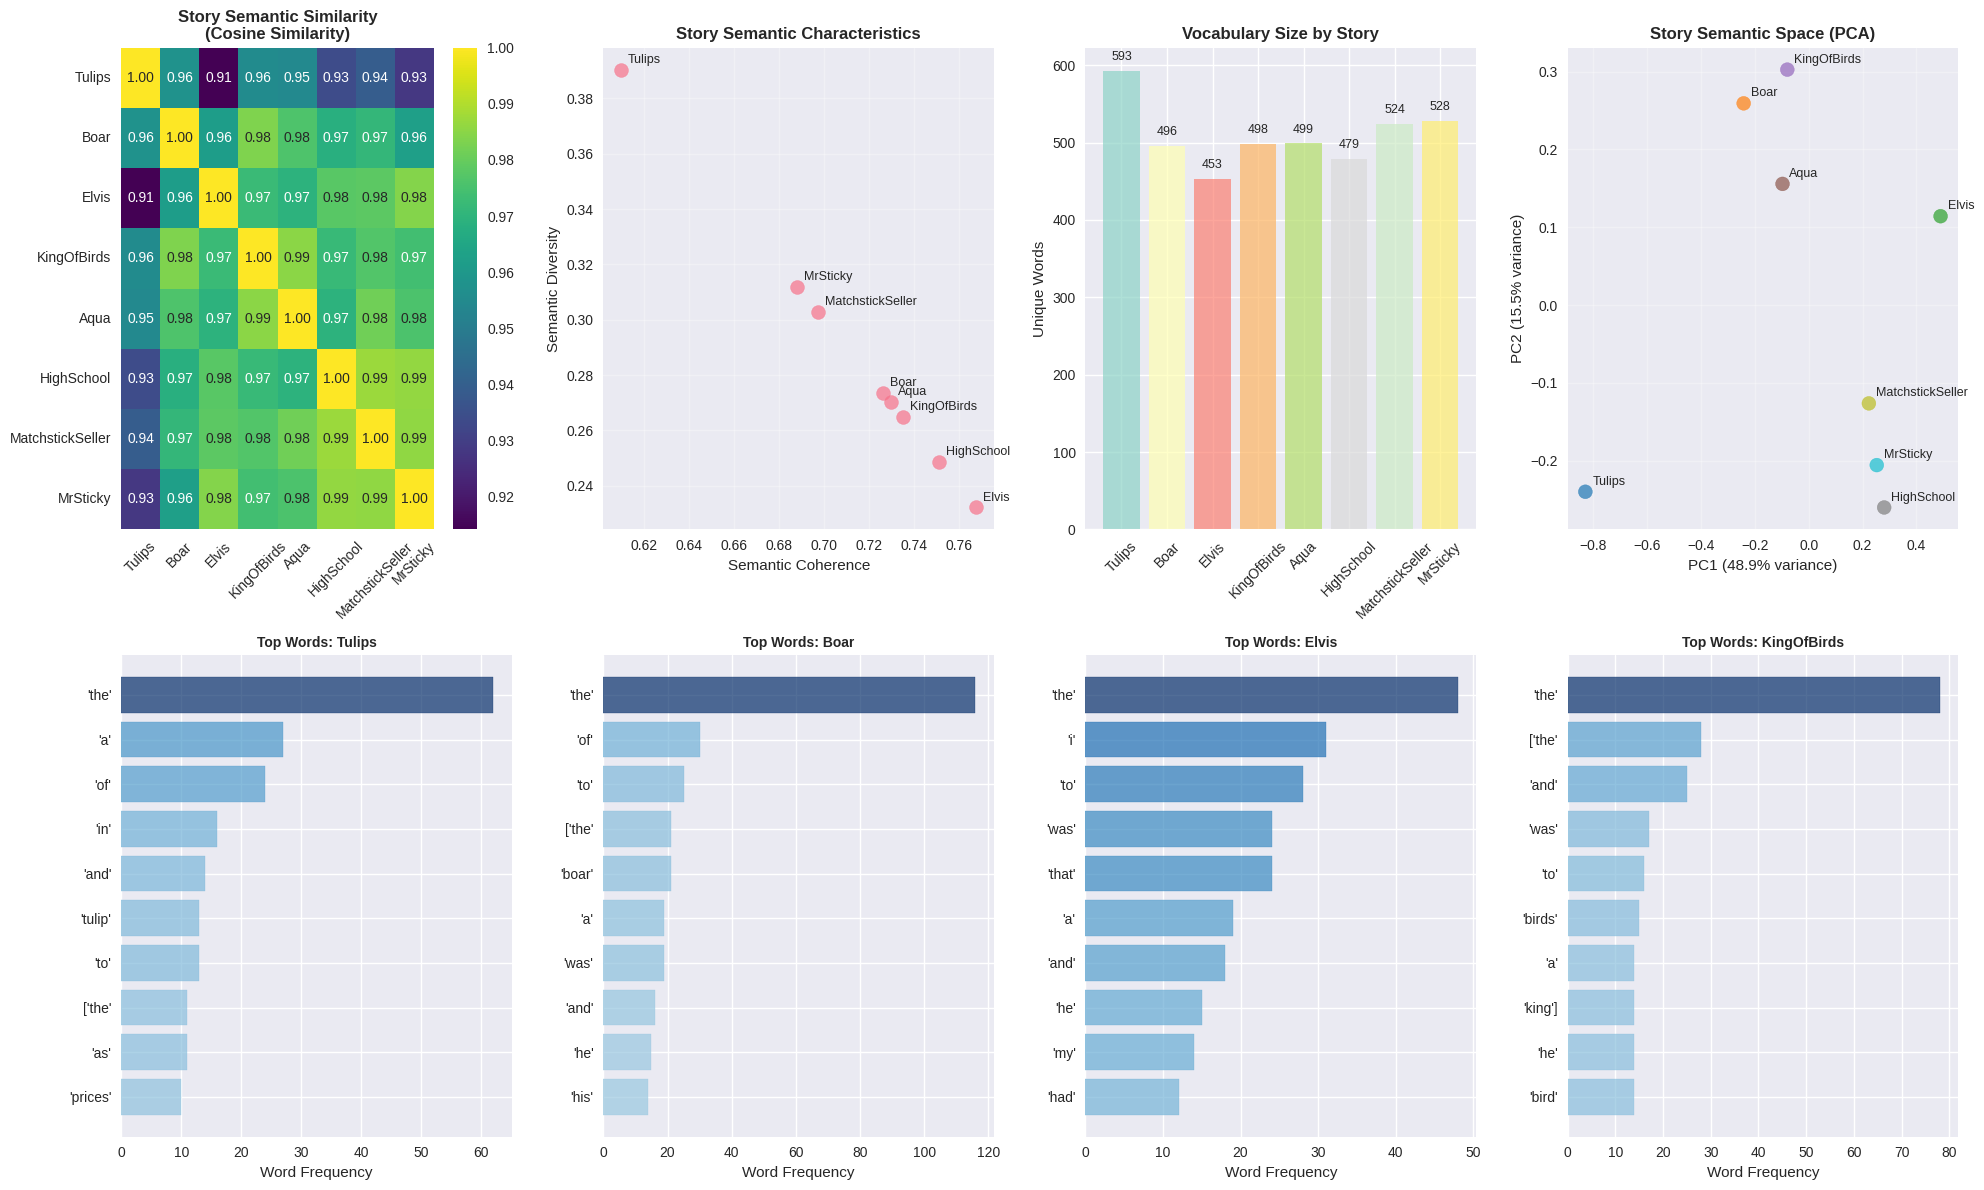


 SEMANTIC STORY CHARACTERIZATION

 **Tulips**
   • semantically diverse (0.390 diversity)
   • rich vocabulary (593 unique words)
   • Key words: 'the', 'a', 'of', 'in', 'and'
   • Semantic coherence: 0.610

 **MrSticky**
   • semantically diverse (0.312 diversity)
   • rich vocabulary (528 unique words)
   • Key words: 'the', 'to', 'was', 'she', 'abby'
   • Semantic coherence: 0.688

 **MatchstickSeller**
   • semantically diverse (0.303 diversity)
   • rich vocabulary (524 unique words)
   • Key words: 'the', 'a', 'she', 'her', ['the'
   • Semantic coherence: 0.697

 **Boar**
   • moderately diverse (0.274 diversity)
   • rich vocabulary (496 unique words)
   • Key words: 'the', 'of', 'to', ['the', 'boar'
   • Semantic coherence: 0.726

 **Aqua**
   • moderately diverse (0.270 diversity)
   • rich vocabulary (499 unique words)
   • Key words: 'the', 'and', 'a', ['and', 'of'
   • Semantic coherence: 0.730

 **KingOfBirds**
   • moderately diverse (0.265 diversity)
   • rich vocabular

In [41]:
semantic_results = run_semantic_story_analysis(filtered_df)

In [45]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def analyze_story_progression(df):
    unique_stories = df['docid'].unique()
    unique_frois = df['fROI'].unique()

    print(f" Dataset Overview:")
    print(f"   Stories: {len(unique_stories)}")
    print(f"   Brain regions (fROIs): {len(unique_frois)}")
    print(f"   Subjects: {df['subject'].nunique()}")
    print(f"   Total observations: {len(df)}")
    print(f"   Stories: {list(unique_stories)}")
    print(f"   Brain regions: {list(unique_frois)}")
    print("="*80)

    return unique_stories, unique_frois

def create_story_progression_plots(df, story_id, save_plots=True):
    story_data = df[df['docid'] == story_id].copy()
    unique_frois = story_data['fROI'].unique()

    story_avg = story_data.groupby(['time', 'fROI'])['BOLD'].agg(['mean', 'std', 'count']).reset_index()
    story_avg.columns = ['time', 'fROI', 'bold_mean', 'bold_std', 'n_subjects']

    story_avg['bold_se'] = story_avg['bold_std'] / np.sqrt(story_avg['n_subjects'])

    n_regions = len(unique_frois)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'BOLD Response Progression: {story_id}', fontsize=16, fontweight='bold')

    axes = axes.flatten()

    for i, froi in enumerate(unique_frois):
        if i >= len(axes):
            break

        # Get data for this brain region
        region_data = story_avg[story_avg['fROI'] == froi].copy()
        region_data = region_data.sort_values('time')

        # Plot with error bars
        axes[i].plot(region_data['time'], region_data['bold_mean'],
                    linewidth=2, marker='o', markersize=3, alpha=0.8)
        axes[i].fill_between(region_data['time'],
                           region_data['bold_mean'] - region_data['bold_se'],
                           region_data['bold_mean'] + region_data['bold_se'],
                           alpha=0.3)

        axes[i].set_title(f'{froi}', fontweight='bold', fontsize=12)
        axes[i].set_xlabel('Time (story progression)')
        axes[i].set_ylabel('BOLD Response')
        axes[i].grid(True, alpha=0.3)

        # Add some statistics
        bold_range = region_data['bold_mean'].max() - region_data['bold_mean'].min()
        bold_mean = region_data['bold_mean'].mean()
        axes[i].text(0.02, 0.98, f'Range: {bold_range:.3f}\nMean: {bold_mean:.3f}',
                    transform=axes[i].transAxes, fontsize=9,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Remove empty subplots
    for i in range(len(unique_frois), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()

    if save_plots:
        plt.savefig(f'story_progression_{story_id}.png', dpi=300, bbox_inches='tight')

    plt.show()

    return story_avg

def calculate_bold_statistics(df):

    print(" BOLD Response Statistics by Story and Brain Region")
    print("="*80)

    # Calculate statistics grouped by story and brain region
    stats_df = df.groupby(['docid', 'fROI'])['BOLD'].agg([
        'count', 'mean', 'std', 'min', 'max',
        lambda x: x.max() - x.min(),  # range
        lambda x: np.percentile(x, 25),  # Q1
        lambda x: np.percentile(x, 75),  # Q3
    ]).round(4)

    stats_df.columns = ['N_obs', 'Mean', 'Std', 'Min', 'Max', 'Range', 'Q1', 'Q3']

    stats_df['CV'] = (stats_df['Std'] / abs(stats_df['Mean'])).round(4)

    stats_df = stats_df.reset_index()

    return stats_df

def analyze_story_patterns(df):

    print(" Cross-Story Pattern Analysis")
    print("="*80)

    # Calculate story-level statistics
    story_stats = df.groupby(['docid', 'fROI']).agg({
        'BOLD': ['mean', 'std', 'min', 'max'],
        'totsurp_hrf': 'mean',
        'fwprob5surp_hrf': 'mean',
        'gpt2_surp_hrf': 'mean'
    }).round(4)

    # Flatten column names
    story_stats.columns = ['_'.join(col).strip() for col in story_stats.columns]
    story_stats = story_stats.reset_index()

    # Calculate BOLD range
    story_stats['BOLD_range'] = story_stats['BOLD_max'] - story_stats['BOLD_min']

    # Find most/least variable regions per story
    print("Most Variable Brain Regions (by BOLD range) per Story:")
    for story in df['docid'].unique():
        story_data = story_stats[story_stats['docid'] == story]
        most_variable = story_data.loc[story_data['BOLD_range'].idxmax()]
        least_variable = story_data.loc[story_data['BOLD_range'].idxmin()]

        print(f"\n  {story}:")
        print(f"    Most variable:  {most_variable['fROI']} (range: {most_variable['BOLD_range']:.4f})")
        print(f"    Least variable: {least_variable['fROI']} (range: {least_variable['BOLD_range']:.4f})")

    return story_stats

def create_summary_heatmap(stats_df):
    mean_pivot = stats_df.pivot(index='fROI', columns='docid', values='Mean')
    range_pivot = stats_df.pivot(index='fROI', columns='docid', values='Range')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Mean BOLD heatmap
    sns.heatmap(mean_pivot, annot=True, fmt='.3f', cmap='RdBu_r',
                center=0, ax=ax1, cbar_kws={'label': 'Mean BOLD'})
    ax1.set_title('Mean BOLD Response by Region and Story', fontweight='bold')
    ax1.set_ylabel('Brain Region (fROI)')
    ax1.set_xlabel('Story')

    # BOLD range heatmap
    sns.heatmap(range_pivot, annot=True, fmt='.3f', cmap='viridis',
                ax=ax2, cbar_kws={'label': 'BOLD Range'})
    ax2.set_title('BOLD Response Range by Region and Story', fontweight='bold')
    ax2.set_ylabel('Brain Region (fROI)')
    ax2.set_xlabel('Story')

    plt.tight_layout()
    plt.savefig('bold_summary_heatmaps.png', dpi=300, bbox_inches='tight')
    plt.show()

def correlation_analysis(df):
    print("Correlation Analysis: BOLD vs Surprisal Measures")
    print("="*80)

    # Calculate correlations for each story and brain region
    corr_results = []

    for story in df['docid'].unique():
        for froi in df['fROI'].unique():
            subset = df[(df['docid'] == story) & (df['fROI'] == froi)]

            if len(subset) > 5:  # Need sufficient data points
                # Calculate correlations
                corr_pcfg = subset['BOLD'].corr(subset['totsurp_hrf'])
                corr_5gram = subset['BOLD'].corr(subset['fwprob5surp_hrf'])
                corr_gpt2 = subset['BOLD'].corr(subset['gpt2_surp_hrf'])

                corr_results.append({
                    'story': story,
                    'fROI': froi,
                    'corr_pcfg': corr_pcfg,
                    'corr_5gram': corr_5gram,
                    'corr_gpt2': corr_gpt2,
                    'n_obs': len(subset)
                })

    corr_df = pd.DataFrame(corr_results)

    # Summary statistics
    print("Average correlations across all story-region combinations:")
    print(f"  PCFG Surprisal:  {corr_df['corr_pcfg'].mean():.4f} ± {corr_df['corr_pcfg'].std():.4f}")
    print(f"  5-gram Surprisal: {corr_df['corr_5gram'].mean():.4f} ± {corr_df['corr_5gram'].std():.4f}")
    print(f"  GPT-2 Surprisal:  {corr_df['corr_gpt2'].mean():.4f} ± {corr_df['corr_gpt2'].std():.4f}")

    return corr_df

def run_complete_analysis(df):

    print(" Starting Natural Stories fMRI Story Progression Analysis")
    print("="*80)

    unique_stories, unique_frois = analyze_story_progression(df)

    stats_df = calculate_bold_statistics(df)
    print("\n BOLD Statistics Summary (first 10 rows):")
    print(stats_df.head(10))

    # 3. Analyze cross-story patterns
    story_patterns = analyze_story_patterns(df)

    # 4. Create progression plots for each story
    print(f"\n Creating progression plots for {len(unique_stories)} stories...")
    story_data_dict = {}

    for story in unique_stories:
        print(f"   Processing {story}...")
        story_avg = create_story_progression_plots(df, story, save_plots=True)
        story_data_dict[story] = story_avg

    # 5. Create summary heatmaps
    print("\n Creating summary heatmaps...")
    create_summary_heatmap(stats_df)

    # 6. Correlation analysis
    corr_df = correlation_analysis(df)

    return {
        'stats_df': stats_df,
        'story_patterns': story_patterns,
        'correlations': corr_df,
        'story_data': story_data_dict
    }

 Starting Natural Stories fMRI Story Progression Analysis
 Dataset Overview:
   Stories: 8
   Brain regions (fROIs): 6
   Subjects: 78
   Total observations: 191706
   Stories: ['Tulips', 'Boar', 'Elvis', 'KingOfBirds', 'Aqua', 'HighSchool', 'MatchstickSeller', 'MrSticky']
   Brain regions: ['LangLAngG', 'LangLAntTemp', 'LangLIFG', 'LangLIFGorb', 'LangLMFG', 'LangLPostTemp']
 BOLD Response Statistics by Story and Brain Region

 BOLD Statistics Summary (first 10 rows):
  docid           fROI  N_obs    Mean     Std      Min      Max    Range  \
0  Aqua      LangLAngG   3575  0.0578  3.0436 -11.8161  21.0276  32.8437   
1  Aqua   LangLAntTemp   3575  0.1373  2.0920  -9.4807   9.8599  19.3406   
2  Aqua       LangLIFG   3575  0.0928  3.8199 -17.7134  14.0804  31.7938   
3  Aqua    LangLIFGorb   3575  0.0863  4.5406 -38.5706  26.1186  64.6891   
4  Aqua       LangLMFG   3575  0.1197  3.7438 -20.0070  16.9611  36.9681   
5  Aqua  LangLPostTemp   3575  0.1538  2.6056  -9.7250  11.7121  21.437

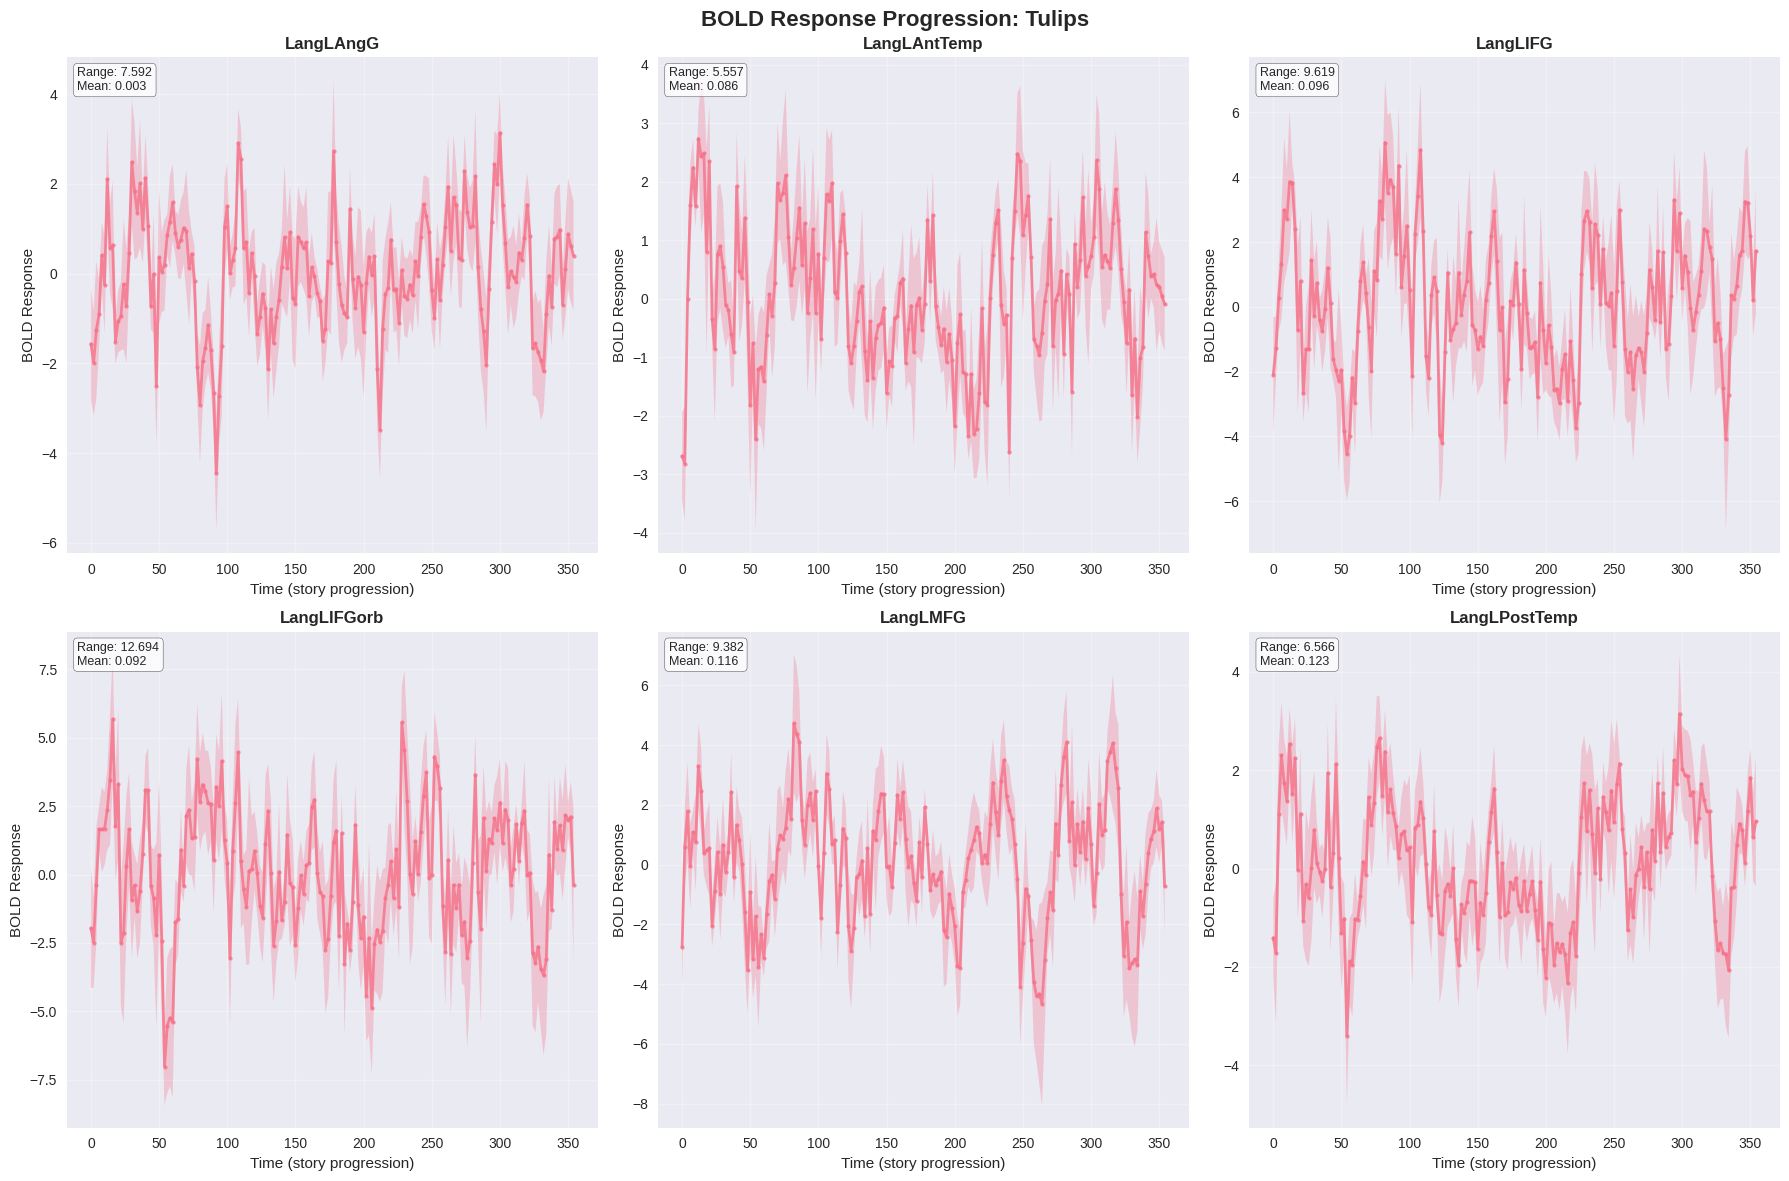

   Processing Boar...


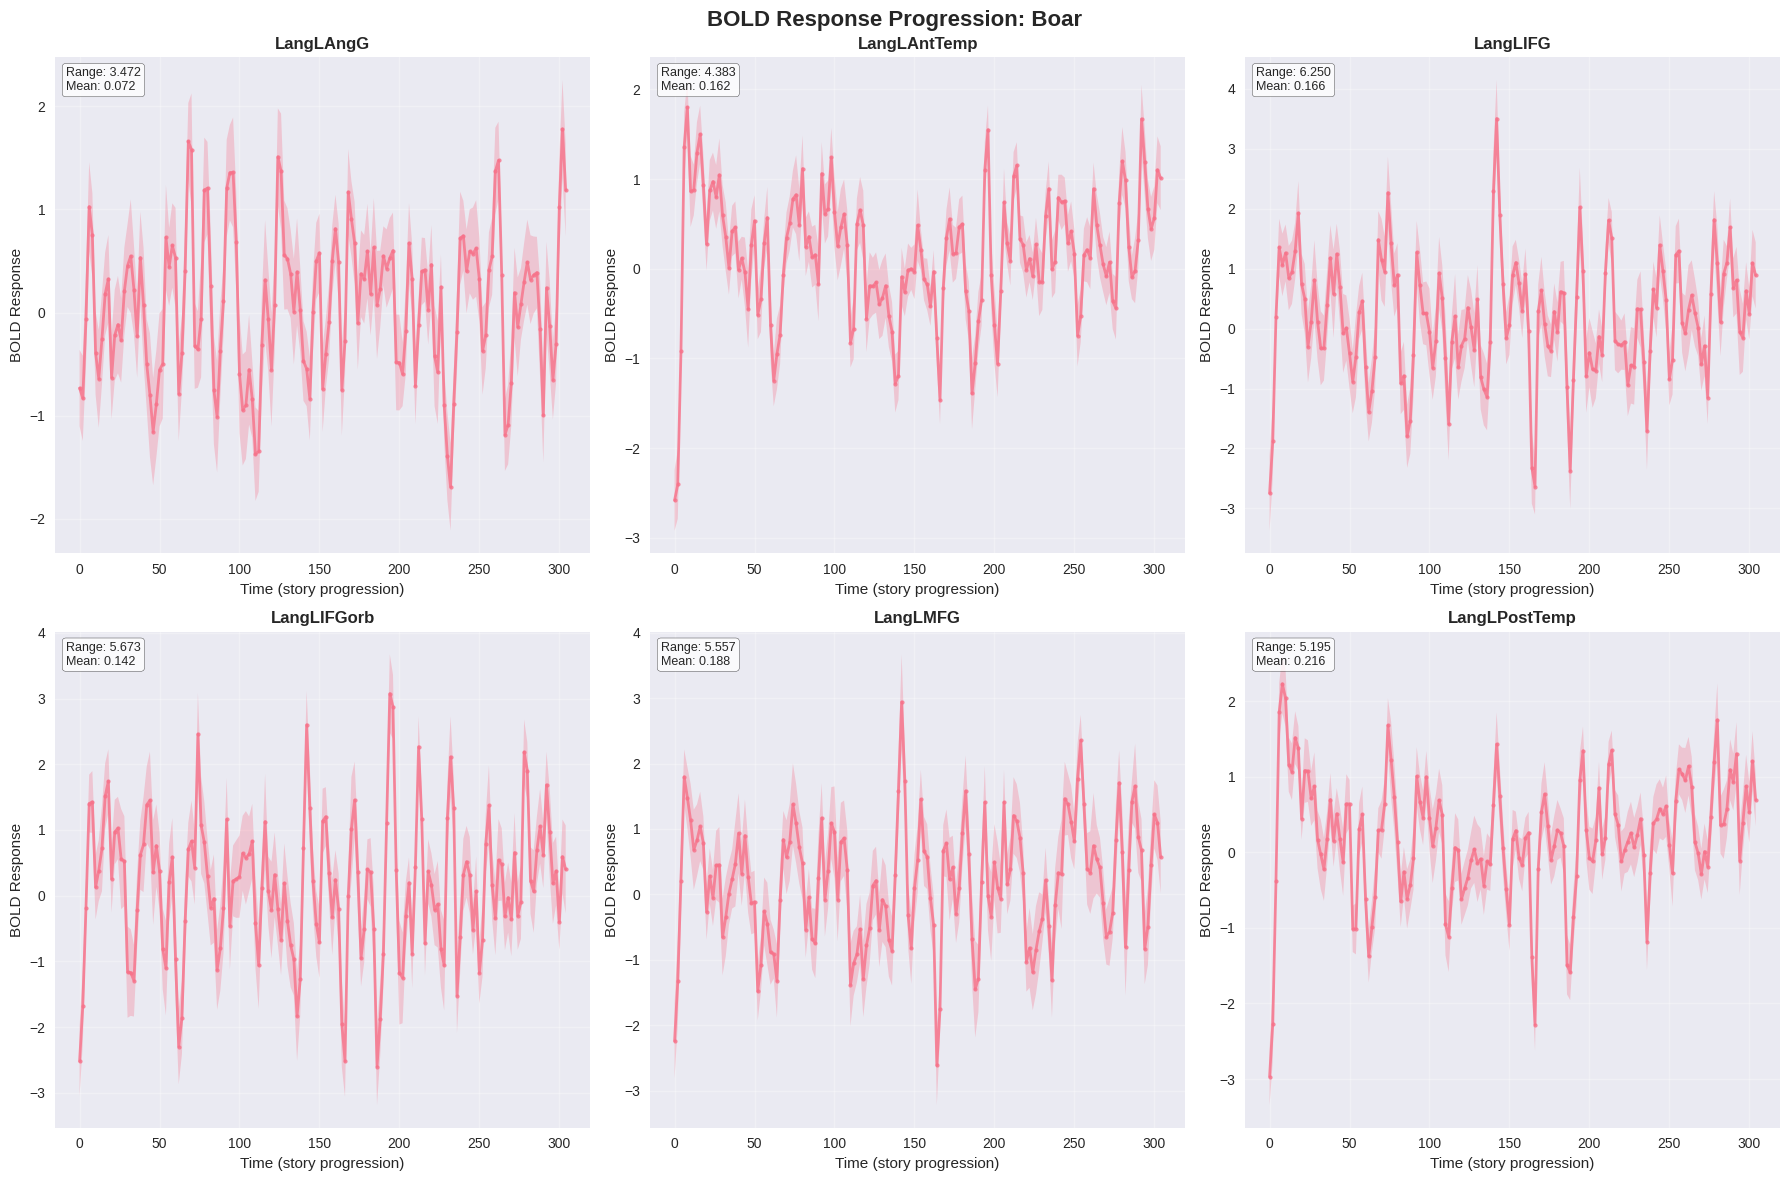

   Processing Elvis...


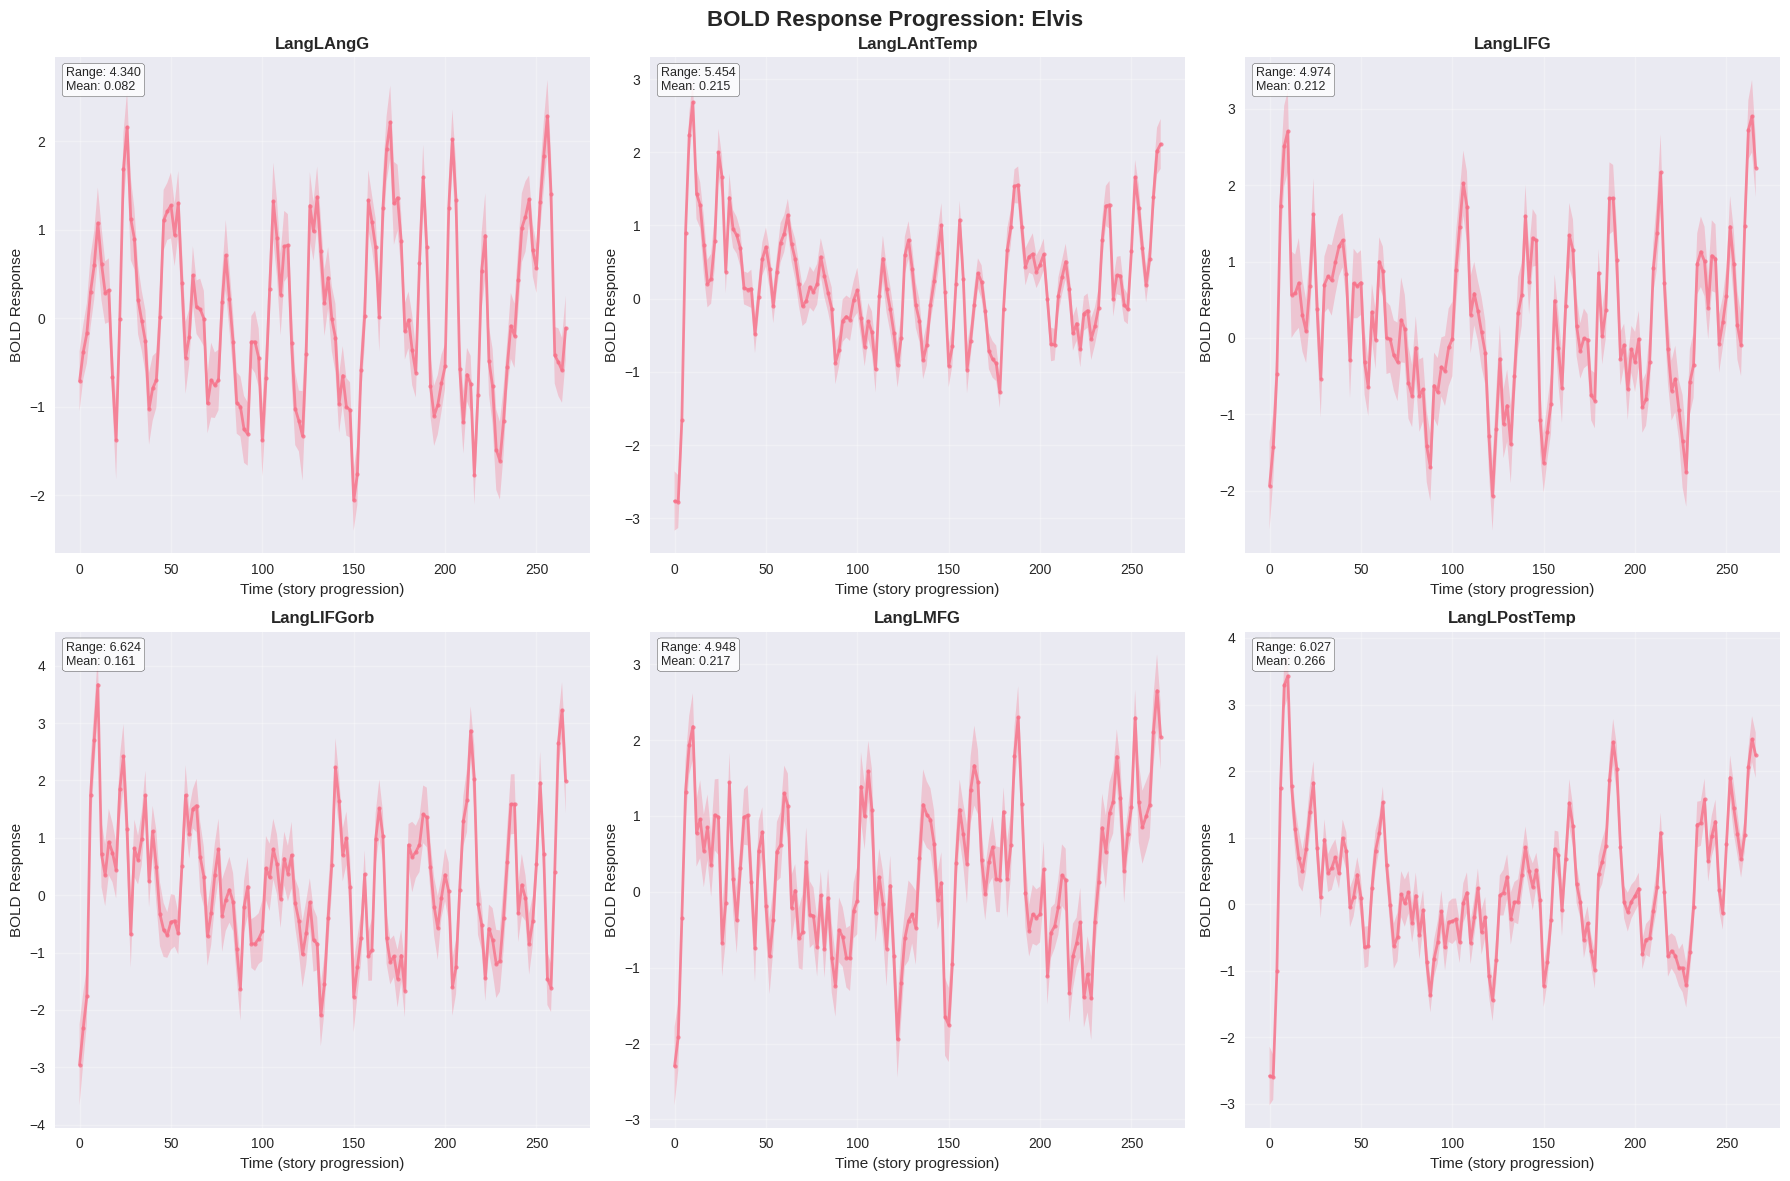

   Processing KingOfBirds...


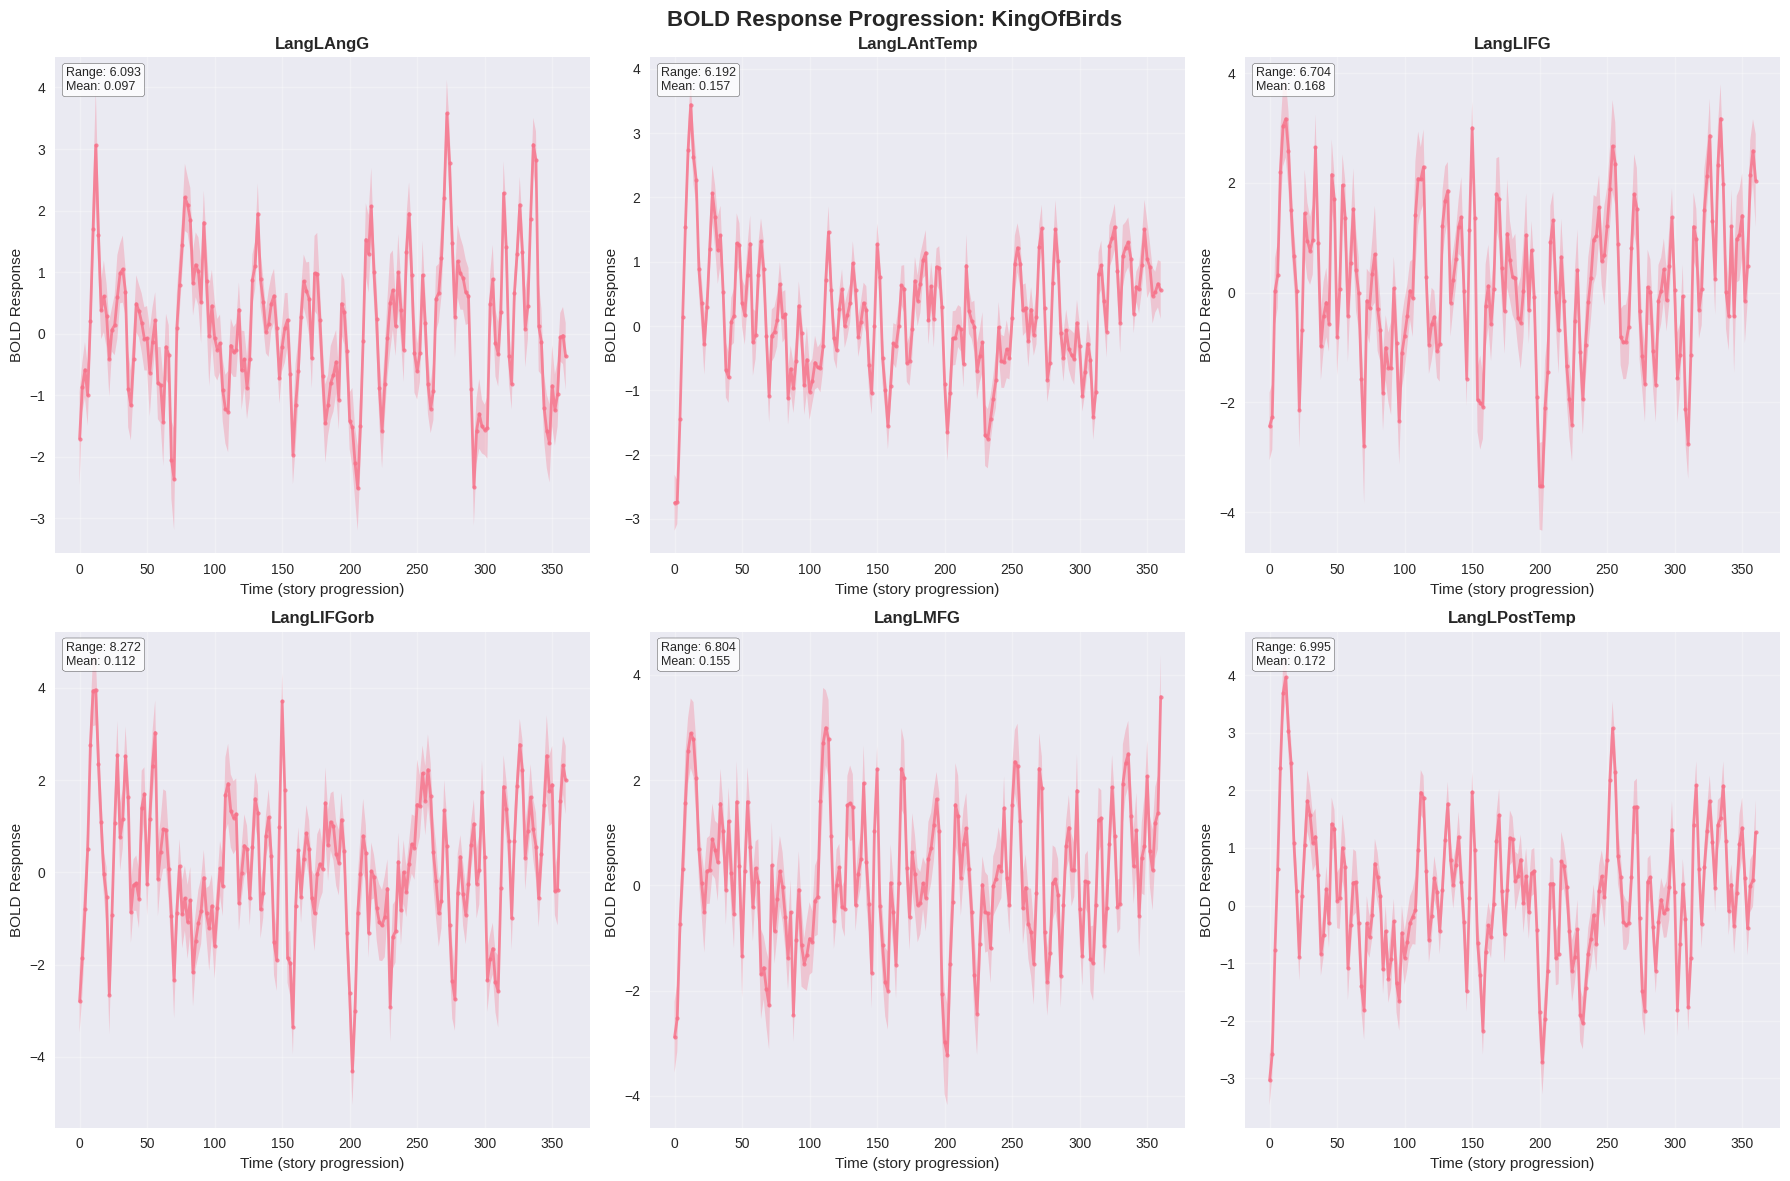

   Processing Aqua...


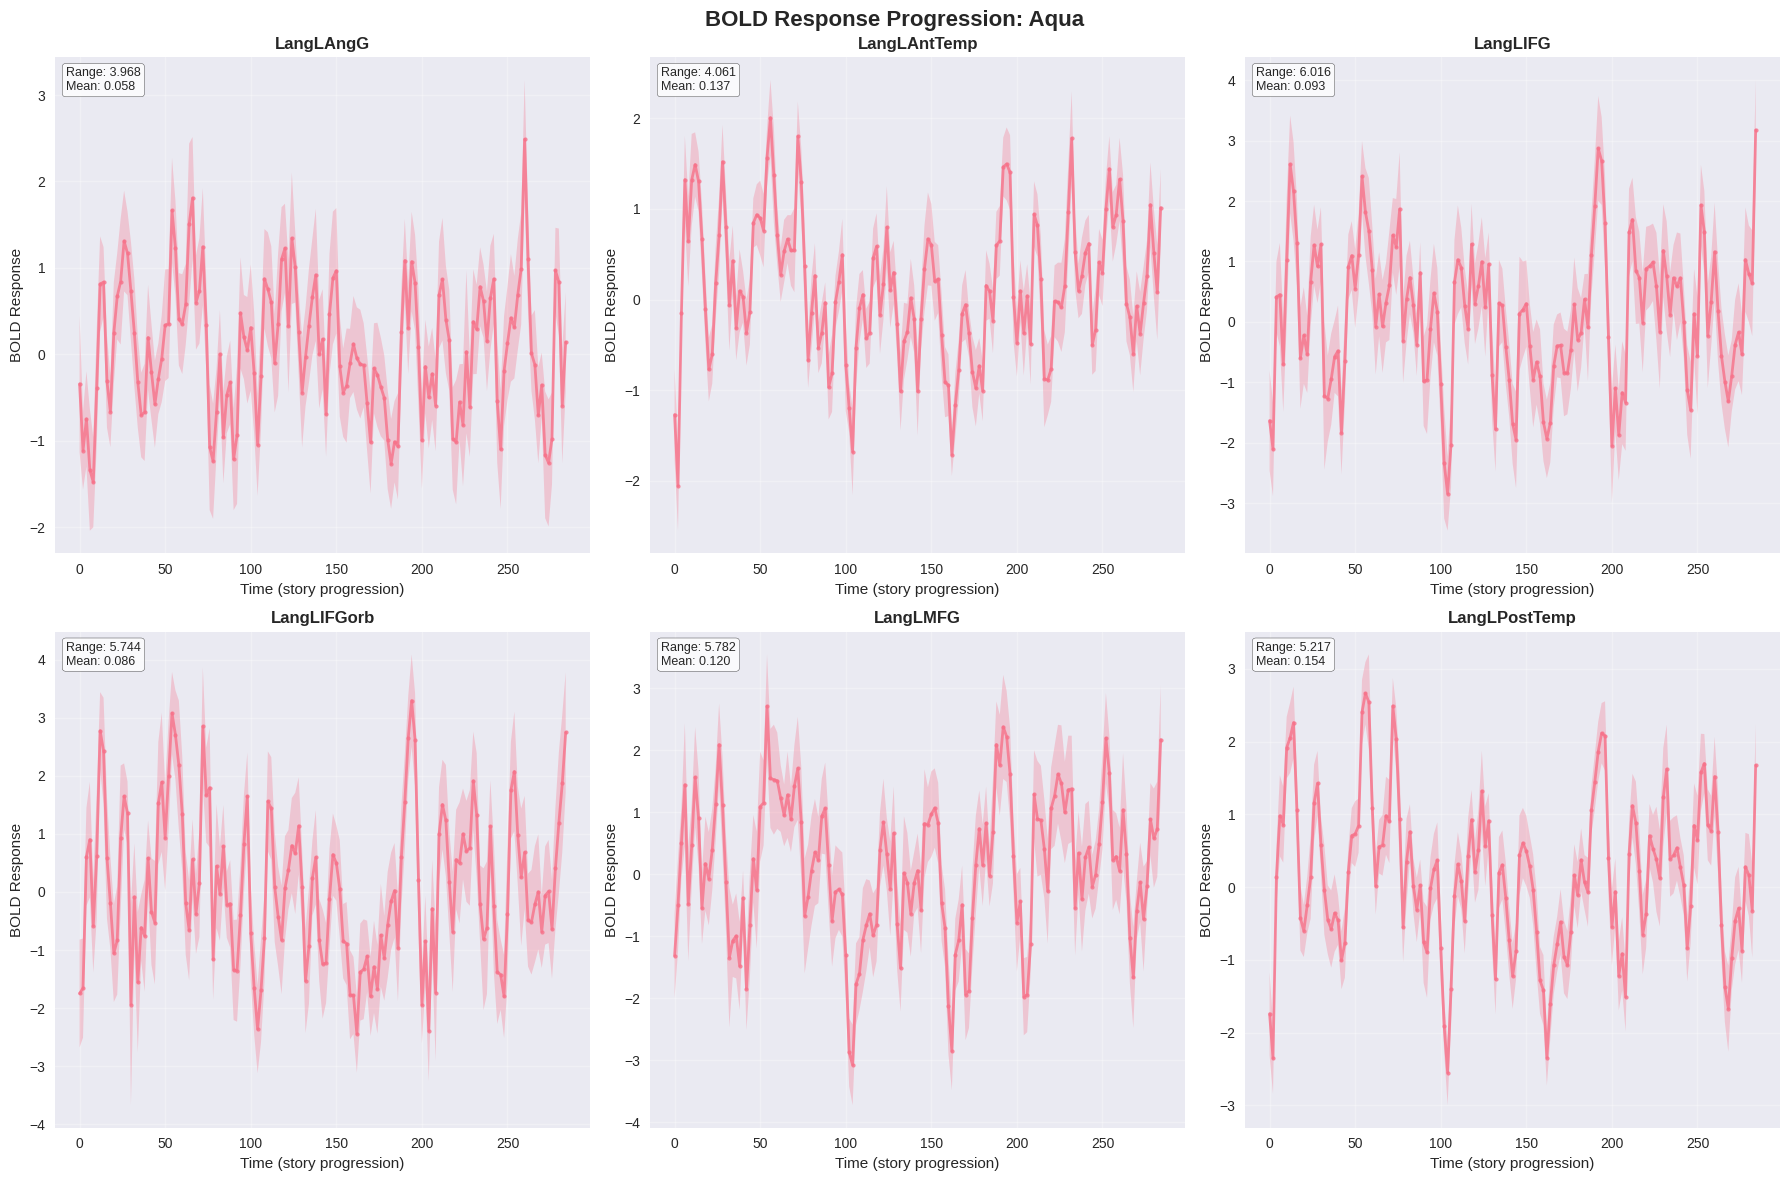

   Processing HighSchool...


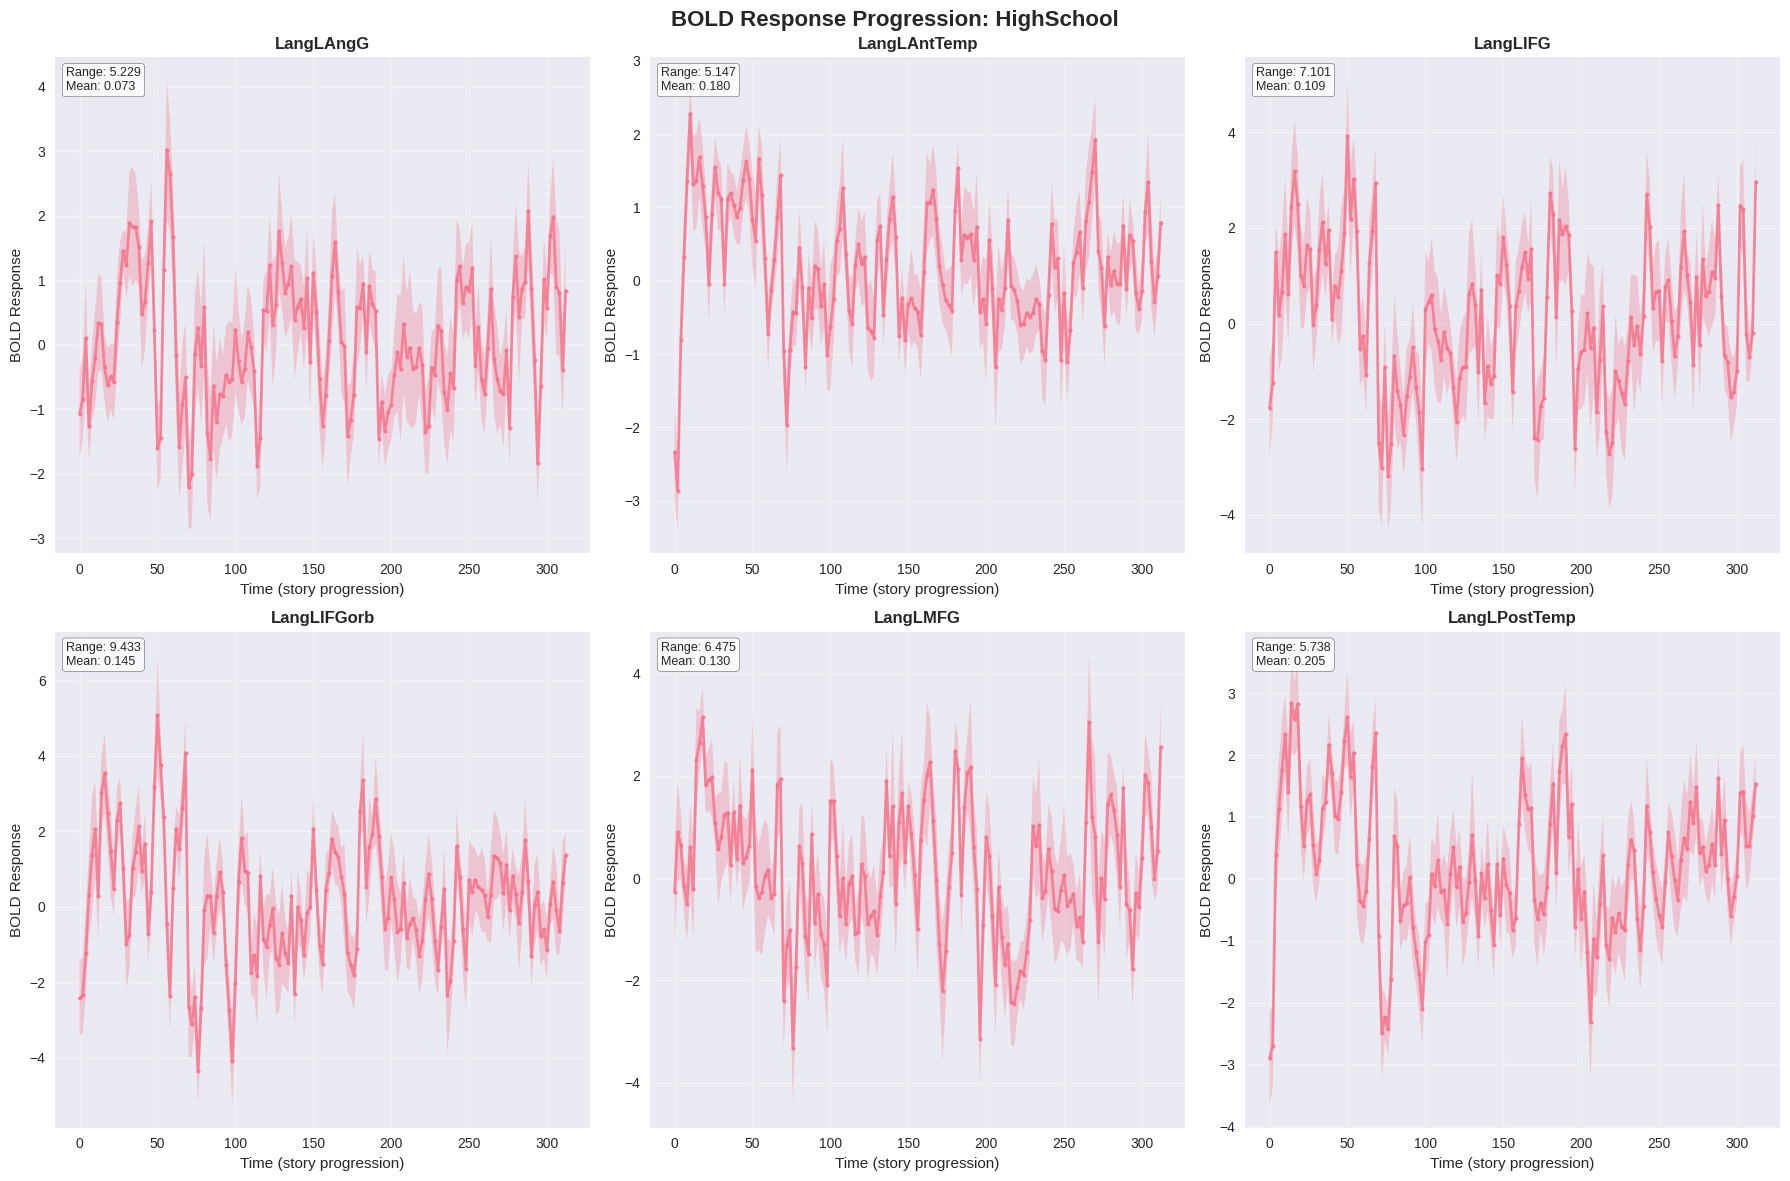

   Processing MatchstickSeller...


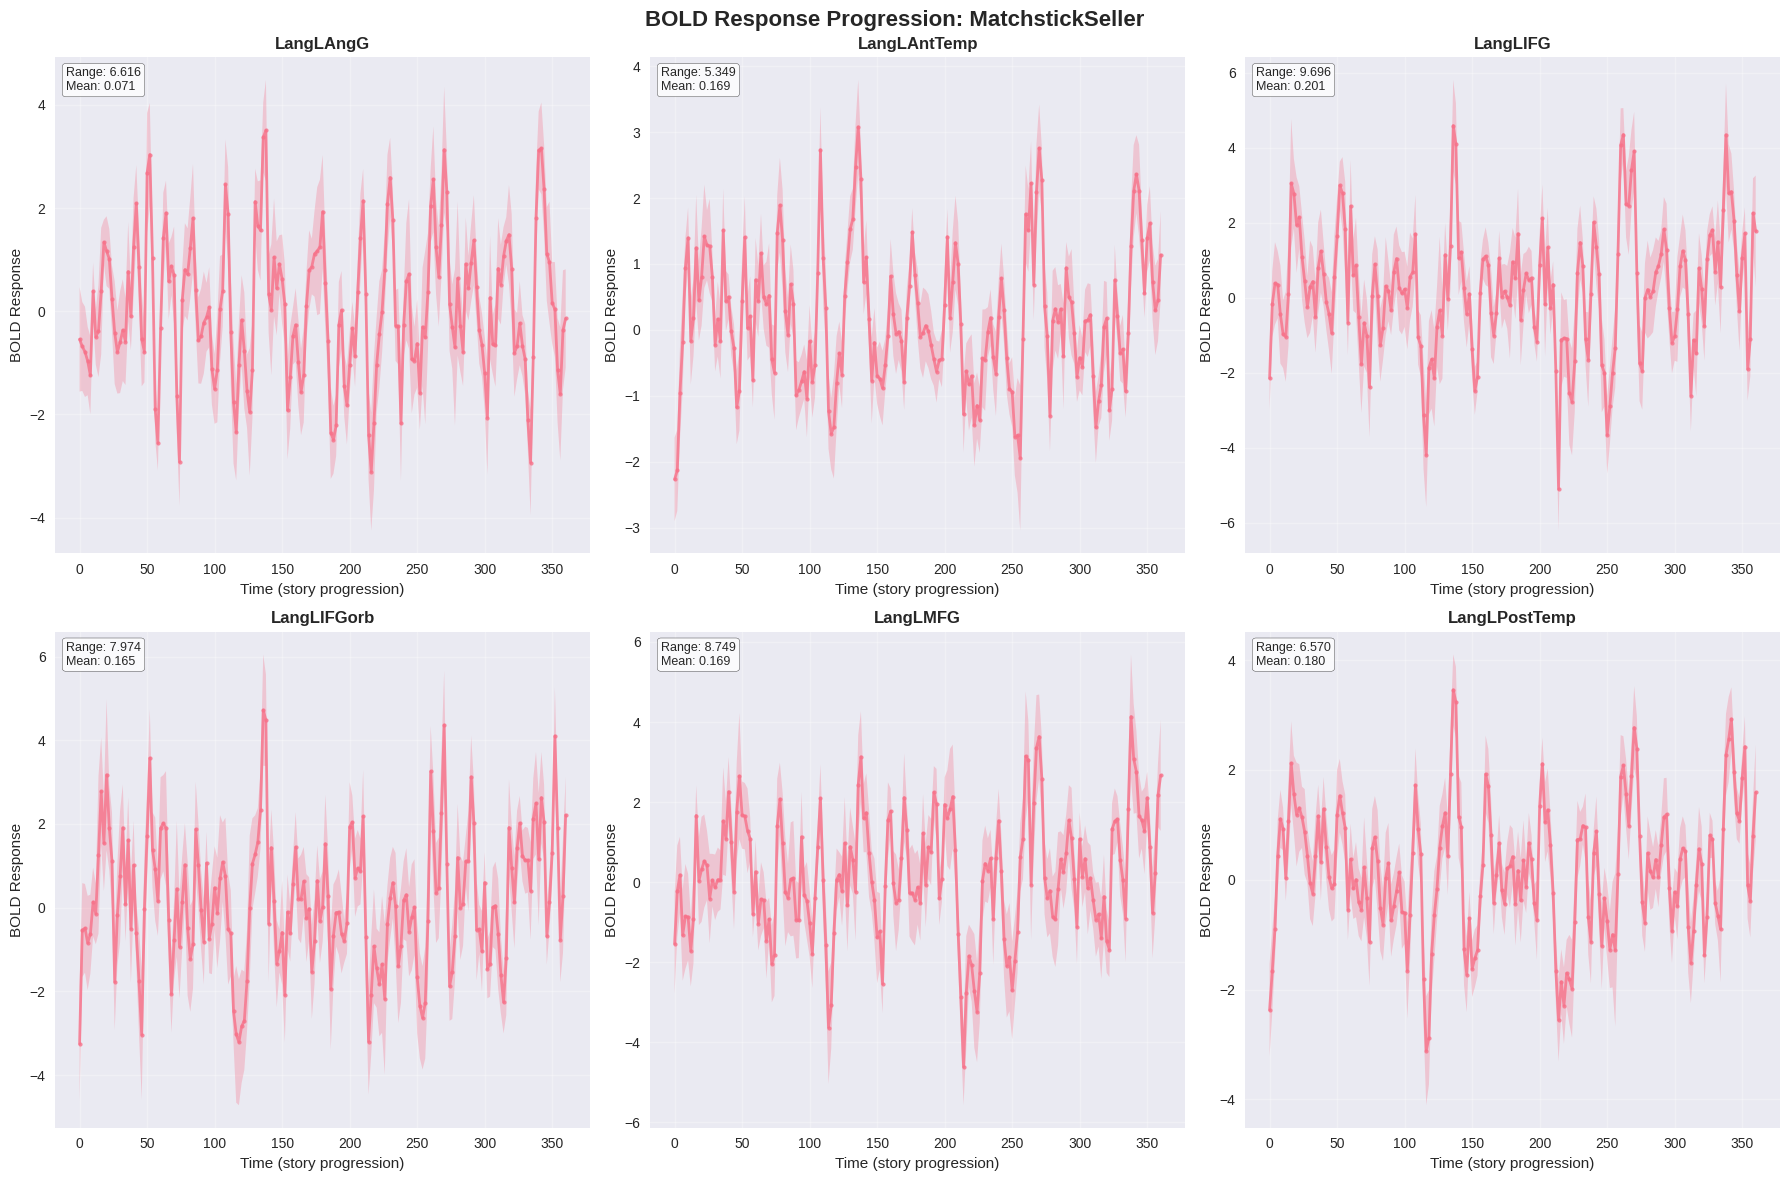

   Processing MrSticky...


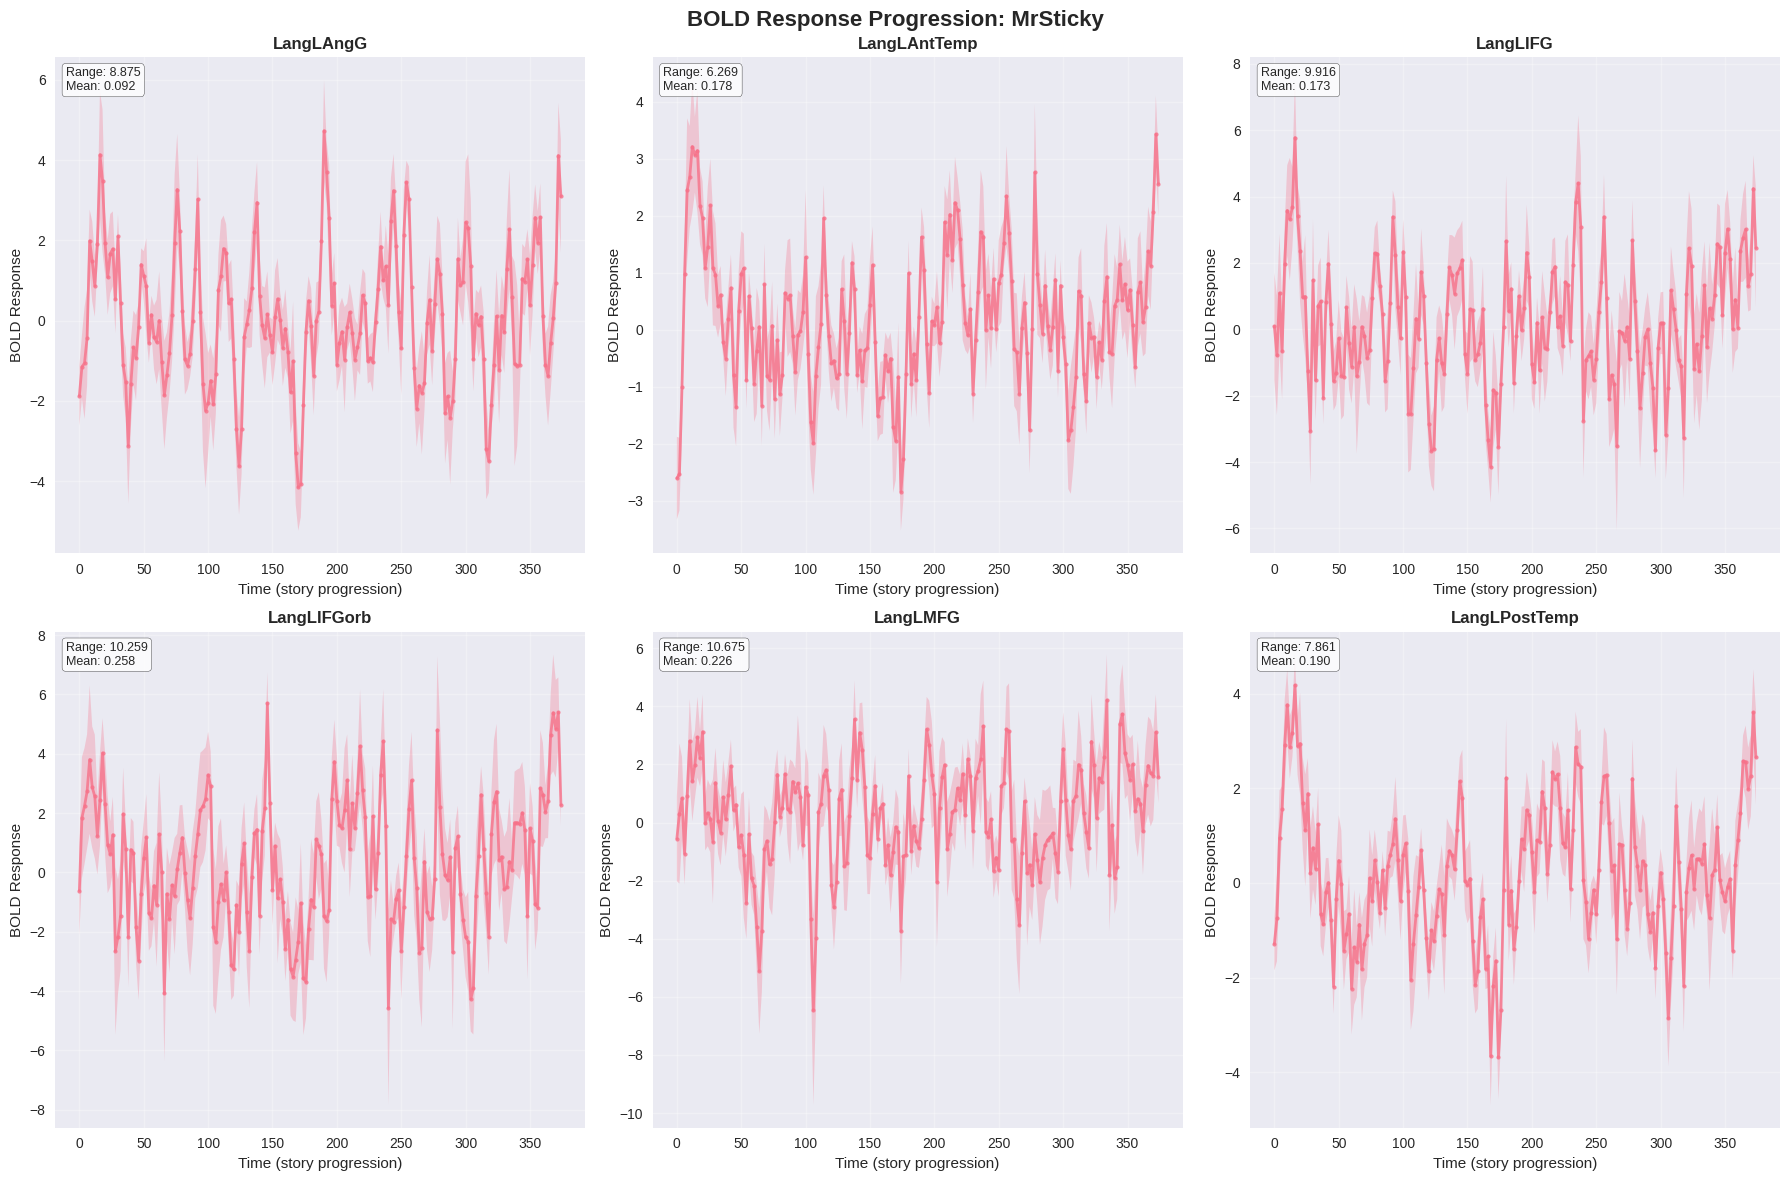


 Creating summary heatmaps...


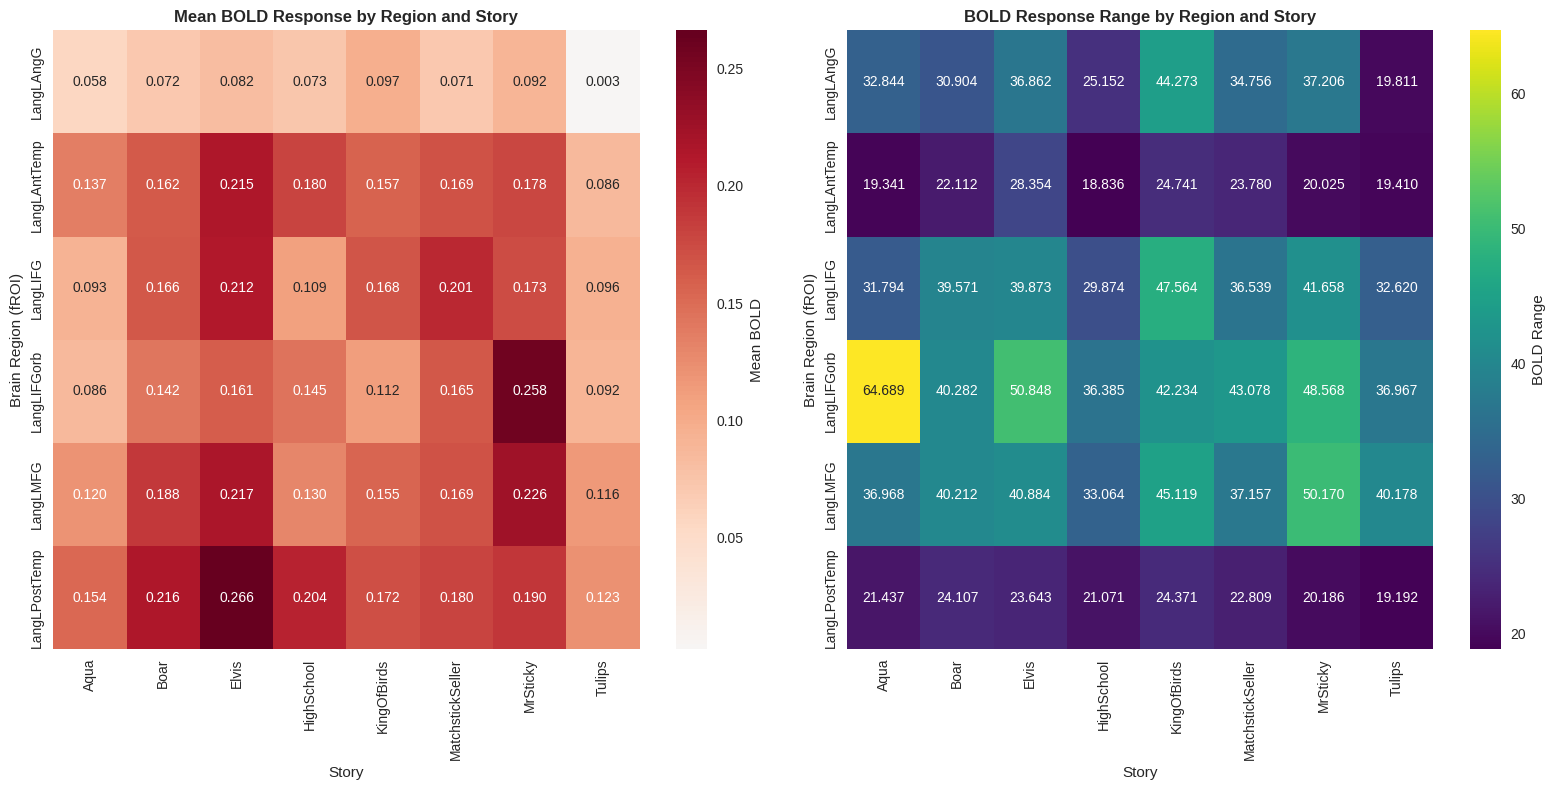

Correlation Analysis: BOLD vs Surprisal Measures
Average correlations across all story-region combinations:
  PCFG Surprisal:  0.0943 ± 0.0476
  5-gram Surprisal: 0.0888 ± 0.0446
  GPT-2 Surprisal:  0.0834 ± 0.0495


In [46]:
results = run_complete_analysis(merged_df_with_vectors)